In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
ox.__version__

'1.3.0'

## Download and prep the street network

In [81]:
# # download the street network
# place = {"city": "Portland", "state": "Maine"}
# network_type = "walk"
# G = ox.graph_from_place(place, network_type=network_type)
# or load from file
G = ox.load_graphml('data/portland.graphml')
G = ox.project_graph(G, 'EPSG:32619') # project the graph to UTM for this zone

## Load census tracts

In [87]:
portland_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=32619&f=json")

In [145]:
tracts = gpd.read_file("data/tl_2022_23_tract.zip").set_index('GEOID').to_crs('EPSG:32619').clip(portland_boundary)

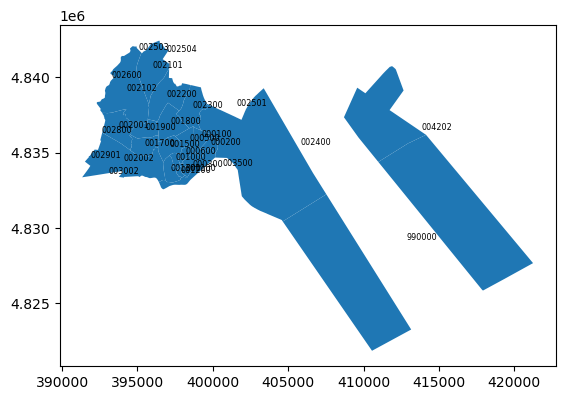

In [146]:
ax = tracts.plot()
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})

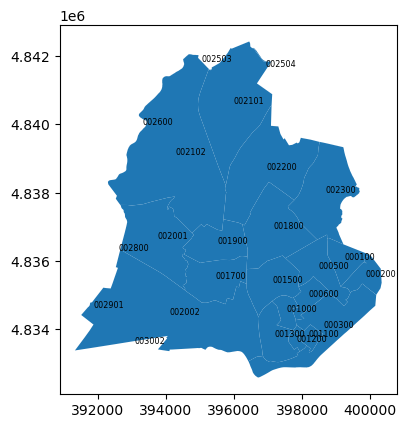

In [147]:
# remove islands
tracts = tracts.drop(['23005990000', '23005004202', '23005002400', '23005003500', '23005002501'])
ax = tracts.plot()
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})

In [148]:
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids]
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

<AxesSubplot: >

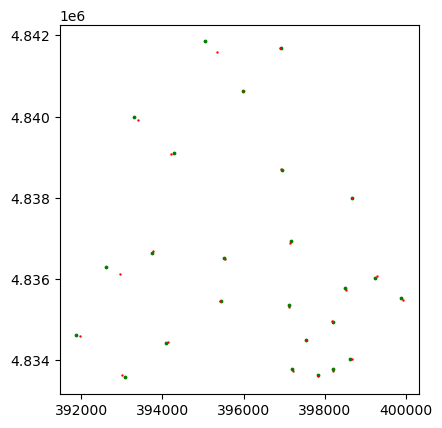

In [153]:
# visually verify that nearest nodes appear correct
fig, ax = plt.subplots()
tracts.centroid.plot(ax=ax, color='green', markersize=3)
center_nodes_gdf.plot(ax=ax, color='red', markersize=0.5)

## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [157]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [158]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [159]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Plotting node 101625302


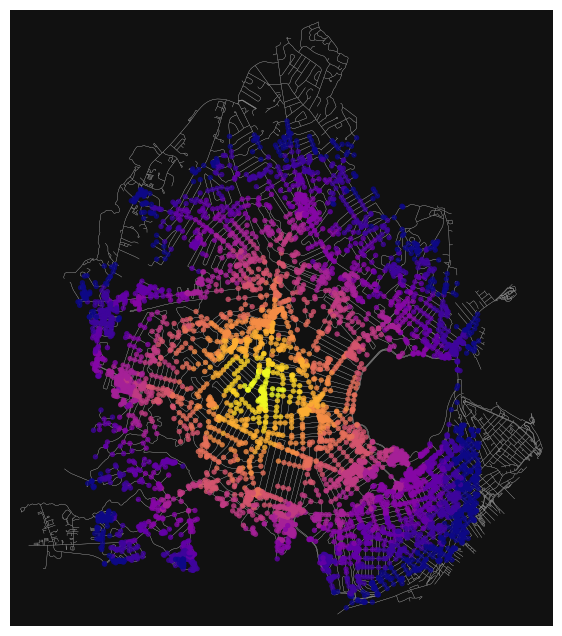

In [170]:
center_node = center_nodes[18]
print("Plotting node {}".format(center_node))
# color the nodes according to isochrone then plot the street network
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [171]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

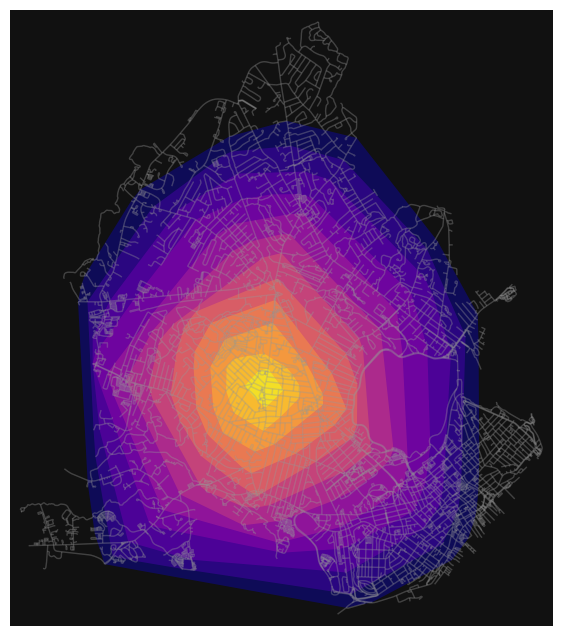

In [172]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

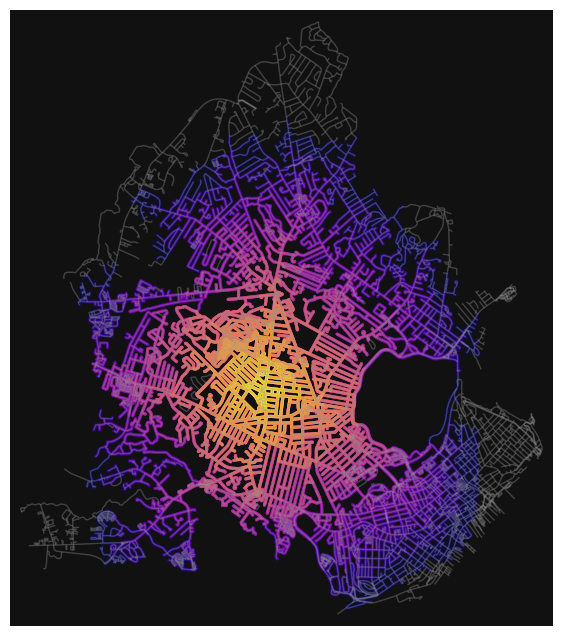

In [173]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=False)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()